In [6]:
import os
import time
from datetime import datetime
import netCDF4
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from sklearn.cluster import DBSCAN

In [2]:
s3bands = [
    'B1-400',
    'B2-412.5',
    'B3-442.5',
    'B4-490',
    'B5-510',
    'B6-560',
    'B7-620',
    'B8-665',
    'B9-673.75',
    'B10-681.25',
    'B11-708.75',
    'B12-753.75',
    'B16-778.75',
    'B17-865',
    'B18-885',
    'B21-1020'
]

# s3bands = [400, 412.5, 442, 490, 510, 560, 620, 665, 674, 681, 709, 754, 779, 865, 885, 1020]

In [3]:
def datafolder_2_list(path):
    return [f for f in path.iterdir() if f.suffix == '.csv']


def open_radiometry(path):
    old_names = [f'Oa{str(i).zfill(2)}_reflectance:float' for i in range(1, 22)]
    [old_names.remove(f'Oa{str(i).zfill(2)}_reflectance:float') for i in range(13,16)]
    [old_names.remove(f'Oa{str(i).zfill(2)}_reflectance:float') for i in range(19,21)]
    df = pd.read_csv(path).rename(columns={old_names[i]: s3bands[i] for i in range(16)})    
    return df


def normalize(df, bands, norm_band):
    df = df.copy()
    df[bands] = df[bands].to_numpy() - df[norm_band].to_numpy()[..., None]
    return df


def clip_negatives(df, bands, threshold=-0.1):
    return df.loc[~((df[bands] < -0.1).any(axis=1))]


def clean_radiometry(df, min_threshold=-0.1, norm_band='B21-1020'):

    if norm_band is not None:
        df = normalize(df, s3bands, 'B21-1020')

    df = clip_negatives(df, s3bands, -0.1)

    return df


def load_radiometries(path, min_pixels=10):

    csvs = [f for f in path.iterdir()]

    radiometries = {}

    for i, csv in enumerate(csvs):
        df = open_radiometry(csvs[i])
        if len(df) > min_pixels:
            radiometries[csv.stem[16:24]] = df
            
    return radiometries


def calc_nd_index(df, band1, band2, column_name='nd_index'):
    idx = (df[band1]-df[band2])/(df[band1]+df[band2])
    df[column_name] = idx
    
    
def db_scan(df, bands, column_name='cluster', eps=0.1, min_samples=5):
    clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(df[bands])
    df[column_name] = clustering.labels_
    

def power(x, a, b, c):return a*(x)**(b) + c


def SPM_GET_Amazon(b665, b865, cutoff_value=0.027, cutoff_delta=0.007, low_params=None, high_params=None, debug=False):

    if debug:
        pdb.set_trace()

    if cutoff_delta == 0:
        transition_coef = np.where(b665<=cutoff_value, 0, 1)

    else:
        transition_range = (cutoff_value - cutoff_delta, cutoff_value + cutoff_delta)
        transition_coef = (b665-transition_range[0])/(transition_range[1]-transition_range[0])

        transition_coef = np.clip(transition_coef, 0, 1)


    # if params are not passed, use default params obtained from the Amazon dataset
    low_params = [2.79101975e+05, 2.34858344e+00, 4.20023206e+00] if low_params is None else low_params
    high_params = [848.97770516,   1.79293191,   8.2788616 ] if high_params is None else high_params

    #low = Fit.power(b665, *low_params).fillna(0)
    #high = Fit.power(b865/b665, *high_params).fillna(0)

    low = power(b665, *low_params).fillna(0)
    high = power(b865/b665, *high_params).fillna(0)


    spm = (1-transition_coef)*low + transition_coef*high
    return spm


# https://stackoverflow.com/questions/29387137/how-to-convert-a-given-ordinal-number-from-excel-to-a-date
def from_excel_ordinal(ordinal, _epoch0=datetime(1899, 12, 31)):
    if ordinal >= 60:
        ordinal -= 1  # Excel leap year bug, 1900 is not a leap year!
    return (_epoch0 + datetime.timedelta(days=ordinal)).replace(microsecond=0)

In [4]:
pd.options.mode.chained_assignment = None  # default='warn'

def create_time_series_cluster(radiometries, eps=0.01, min_samples=5, save_folder=None):
    df = pd.DataFrame()

    for date, radiometry in radiometries.items():

        # clean some outliars  using the indices
        calc_nd_index(radiometry, 'B6-560', 'B21-1020', column_name='mndwi')  # Green / SWIR
        calc_nd_index(radiometry, 'B6-560', 'B17-865', column_name='ndwi')  # Green / IR

        valid_mndwi = (radiometry['mndwi'] > -0.99) & (radiometry['mndwi'] < 0.99)
        valid_ndwi = (radiometry['ndwi'] > -0.99) & (radiometry['ndwi'] < 0.99)

        radiometry = radiometry[valid_mndwi & valid_ndwi]

        if len(radiometry) < min_samples:
            continue 
        
        db_scan(radiometry, ['B17-865', 'B21-1020'], eps=eps, min_samples=min_samples)
        clusters = radiometry.groupby(by='cluster').mean()
        
        if save_folder:
            plt.scatter()
            plt.savefig(save_folder, bbox_inches='tight')
        
        # drop the noise
        clusters.drop(-1, inplace=True, errors='ignore')

        # if there is at least 1 valid cluster
        if len(clusters) > 0:
            df = df.append(clusters[clusters['B21-1020'] == clusters['B21-1020'].min()].iloc[0].rename(date))
        
    
    df['Datestr'] = [f'{i[:4]}-{i[4:6]}-{i[6:]}' for i, row in df.iterrows()]
    df['Date'] = pd.to_datetime(df['Datestr'])
    df.sort_values(by='Date', inplace=True)
    df.reset_index(inplace=True)
    
    return df

In [5]:
def just_open_radiometry(path):
    df = pd.read_csv(path)    
    return df

In [6]:
def just_load_radiometries(path, min_pixels=3):

    csvs = [f for f in path.iterdir()]

    radiometries = {}

    for i, csv in enumerate(csvs):
        df = just_open_radiometry(csvs[i])
        if len(df) > min_pixels:
            radiometries[csv.stem[16:24]] = df
            
    return radiometries

## CAMS 2016:2020

In [8]:
camscsvfolder = Path('D:/A1_JM/artigo_SEN3R/2_mat_met/CAMS')

In [9]:
station2cams = [s for s in os.listdir(camscsvfolder) if s.endswith('.csv')]

In [10]:
cams_station_dict = {}
for s in station2cams:
    sname = s.split('.')[0]
    df = pd.read_csv(camscsvfolder/s)
    cams_station_dict[sname] = df

In [11]:
cams_station_dict.keys()

dict_keys(['an1', 'borba_madeira', 'coari', 'fonte_boa', 'itacoatiara', 'manacapuru', 'negro', 'obidos', 'tefe'])

In [12]:
df_cams_manacapuru = cams_station_dict['manacapuru']
df_cams_manacapuru['pydate'] = pd.to_datetime(df_cams_manacapuru['Datetime'])

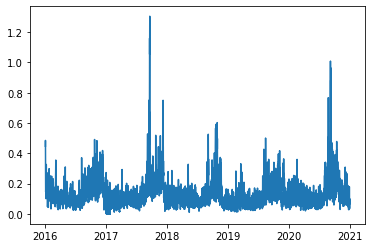

In [13]:
plt.plot(df_cams_manacapuru['pydate'], df_cams_manacapuru['AOD865'])

In [14]:
raw_csvs_folder = Path(r'D:/S3/stations/14100000_manacapuru')
raw_rads = just_load_radiometries(raw_csvs_folder)

In [15]:
csv_dates = [csv.stem[16:24] for csv in raw_csvs_folder.iterdir()]

In [18]:
csv2dates = [datetime.strptime(csv, '%Y%m%d') for csv in csv_dates]

In [45]:
csv2dates = [d.replace(hour=12) for d in csv2dates]

In [46]:
cams_match = df_cams_manacapuru[df_cams_manacapuru['pydate'].isin(csv2dates)]

In [50]:
len(cams_match),len(csv2dates),len(df_cams_manacapuru),len(dbs_manacapuru)

(910, 965, 6942, 351)

In [22]:
radiometries = load_radiometries(Path(r'D:\processing\linux\14100000_manacapuru_v15'))
dbs_manacapuru = create_time_series_cluster(radiometries)

In [60]:
dbs_manacapuru['Date'] = [t.replace(hour=12) for t in dbs_manacapuru['Date']]    

In [62]:
dbs_manacapuru['CAMS'] = dbs_manacapuru['T865:float']

In [85]:
matchCAMS = []
for i, row in dbs_manacapuru.iterrows():
    match = df_cams_manacapuru[df_cams_manacapuru['pydate'] == row['Date']]
    matchCAMS.append(match.AOD865.values[0])

In [86]:
dbs_manacapuru['CAMS'] = matchCAMS

In [96]:
dbs_manacapuru['T865:pi:self'] = (dbs_manacapuru['T865:float']/np.pi)*2

In [87]:
dbs_manacapuru[['T865:float','CAMS']]

T865:float      CAMS
0      0.325669  0.083653
1      0.096210  0.091588
2      0.157786  0.154709
3      0.165582  0.054289
4      0.170992  0.091543
..          ...       ...
346    0.196760  0.122654
347    0.164448  0.062336
348    0.118867  0.084619
349    0.154006  0.170934
350    0.405249  0.081929

[351 rows x 2 columns]

In [107]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [120]:
print(f'R2: {r2_score(dbs_manacapuru["CAMS"]*100,dbs_manacapuru["T865:float"]*100)}') # y_true / y_pred
print(f'RMSE: {rmse(dbs_manacapuru["CAMS"]*100,dbs_manacapuru["T865:float"]*100)}')
print(f'MAPE: {mape(dbs_manacapuru["CAMS"]*100,dbs_manacapuru["T865:float"]*100)}')

R2: -2.719743163158289
RMSE: 14.26908538953509
MAPE: 122.3479719827615


In [134]:
print(f'R2: {r2_score(dbs_manacapuru["CAMS"],dbs_manacapuru["T865pi"])}') # y_true / y_pred
print(f'RMSE: {rmse(dbs_manacapuru["CAMS"],dbs_manacapuru["T865pi"])}')
print(f'MAPE: {mape(dbs_manacapuru["CAMS"],dbs_manacapuru["T865pi"])}')

R2: -0.2941892430395088
RMSE: 0.08416636141540548
MAPE: 47.49744647767336


In [117]:
print(f'R2: {r2_score(dbs_manacapuru["CAMS"],dbs_manacapuru["T865:pi:self"])}') # y_true / y_pred
print(f'RMSE: {rmse(dbs_manacapuru["CAMS"],dbs_manacapuru["T865:pi:self"])}')
print(f'MAPE: {mape(dbs_manacapuru["CAMS"],dbs_manacapuru["T865:pi:self"])}')

R2: -0.07737587466549178
RMSE: 0.07679329155088944
MAPE: 58.91001238410322


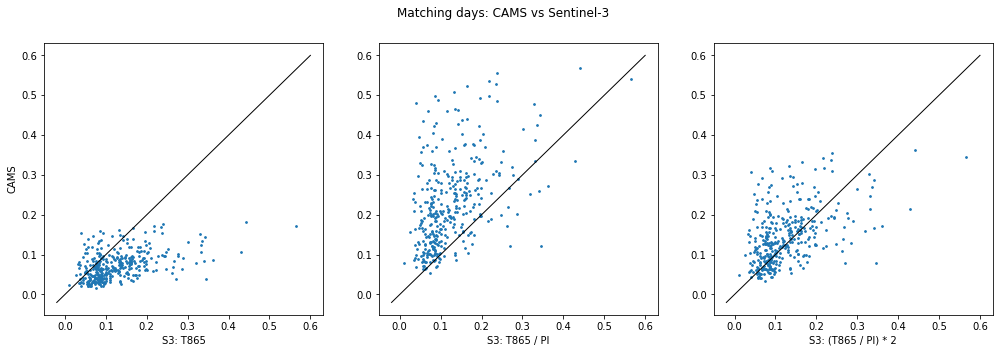

In [128]:
plt.rcParams['figure.figsize'] = [17, 5]
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

fig.suptitle('Matching days: CAMS vs Sentinel-3')

ax2.scatter(dbs_manacapuru["CAMS"], dbs_manacapuru["T865:float"], s=3)
ax1.scatter(dbs_manacapuru["CAMS"], dbs_manacapuru["T865pi"], s=3)
ax3.scatter(dbs_manacapuru["CAMS"], dbs_manacapuru["T865:pi:self"], s=3)


ax1.plot([-0.02, 0.6], [-0.02, 0.6], 'k-', linewidth=1)

ax2.plot([-0.02, 0.6], [-0.02, 0.6], 'k-', linewidth=1)

ax3.plot([-0.02, 0.6], [-0.02, 0.6], 'k-', linewidth=1)
# ax3.text(0.9, 0.1, 'r²', fontsize=12, horizontalalignment='center',
#          verticalalignment='center', transform=ax3.transAxes)

ax1.set_ylabel('CAMS')

ax1.set_xlabel('S3: T865')
ax2.set_xlabel('S3: T865 / PI')
ax3.set_xlabel('S3: (T865 / PI) * 2')

plt.show()
# plt.savefig('compare_s3.png', bbox_inches='tight')

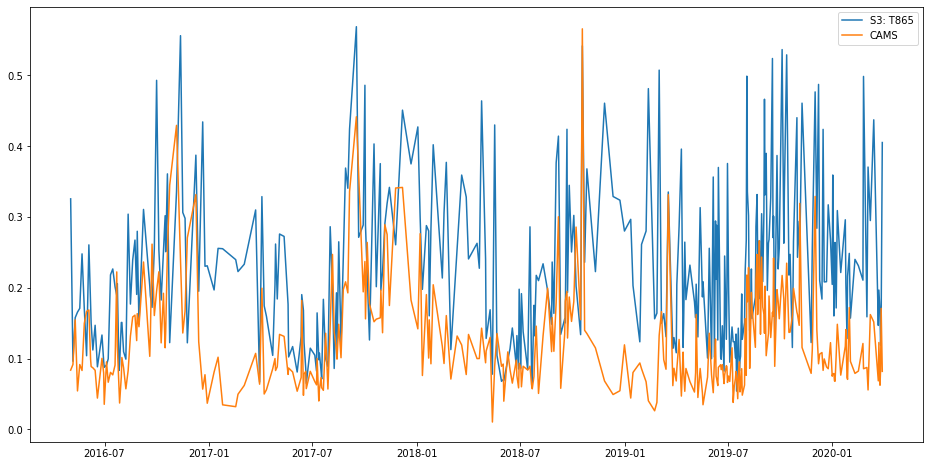

In [133]:
plt.rcParams['figure.figsize'] = [16, 8]
plt.plot(dbs_manacapuru['Date'], dbs_manacapuru['T865:float'],label='S3: T865')
plt.plot(dbs_manacapuru['Date'], dbs_manacapuru['CAMS'],label='CAMS')
# plt.plot(dbs_manacapuru['Date'], dbs_manacapuru['T865:pi:self'])
plt.legend()

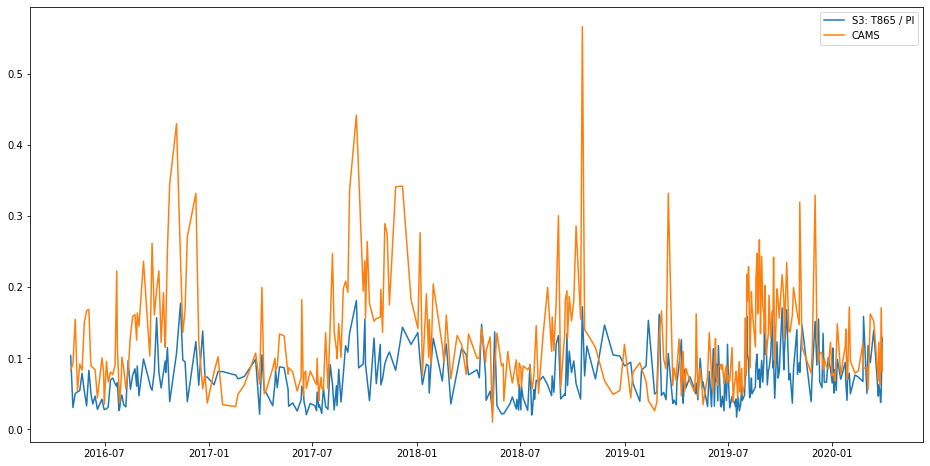

In [130]:
plt.rcParams['figure.figsize'] = [16, 8]
plt.plot(dbs_manacapuru['Date'], dbs_manacapuru['T865pi'],label='S3: T865 / PI')
plt.plot(dbs_manacapuru['Date'], dbs_manacapuru['CAMS'],label='CAMS')
# plt.plot(dbs_manacapuru['Date'], dbs_manacapuru['T865:pi:self'])
plt.legend()

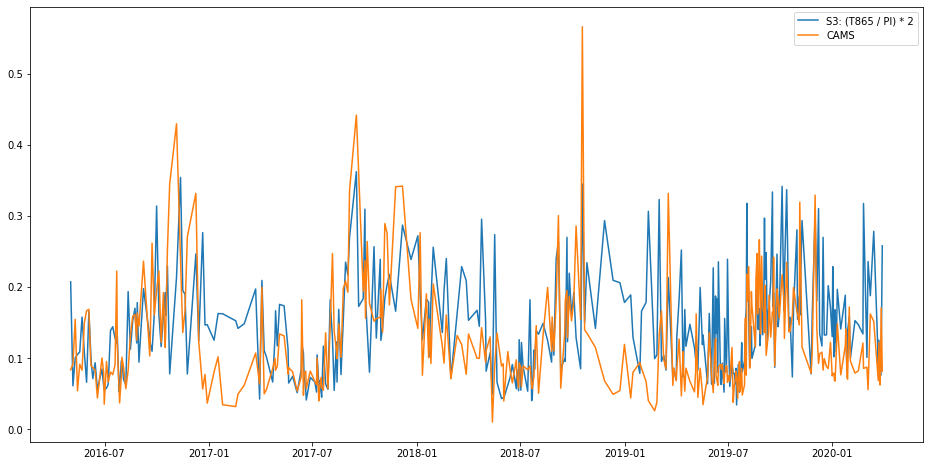

In [132]:
plt.rcParams['figure.figsize'] = [16, 8]
plt.plot(dbs_manacapuru['Date'], dbs_manacapuru['T865:pi:self'],label='S3: (T865 / PI) * 2')
plt.plot(dbs_manacapuru['Date'], dbs_manacapuru['CAMS'],label='CAMS')
# plt.plot(dbs_manacapuru['Date'], dbs_manacapuru['T865:pi:self'])
plt.legend()

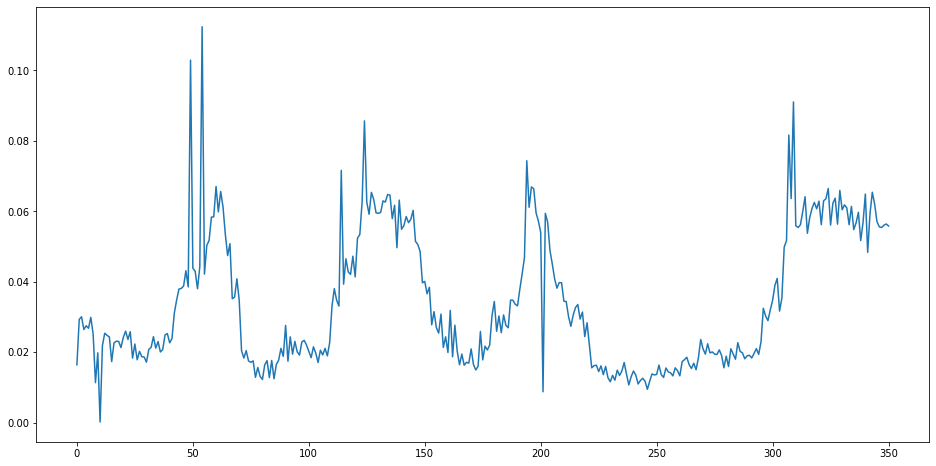

In [104]:
plt.plot(dbs_manacapuru['B17-865'])

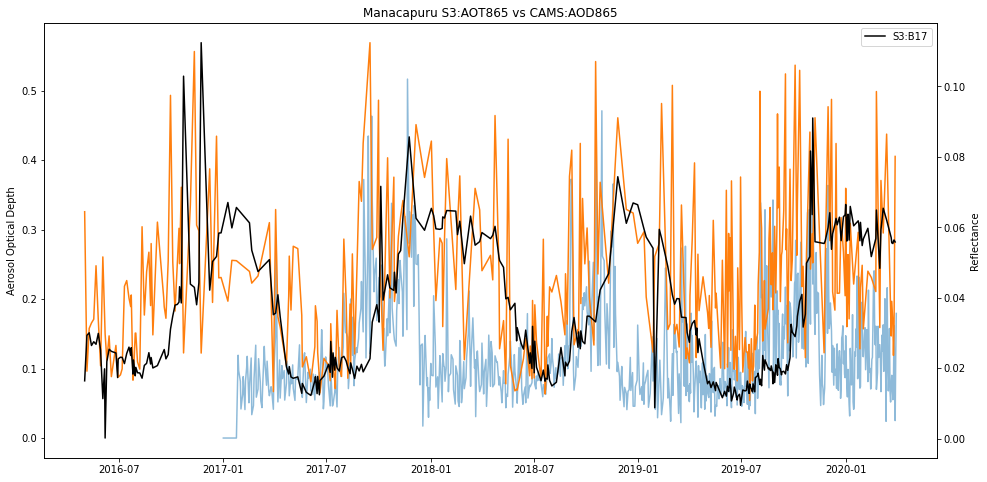

In [24]:
plt.rcParams['figure.figsize'] = [16, 8]
fig, ax = plt.subplots()

plt.title('Manacapuru S3:AOT865 vs CAMS:AOD865')
ax.plot(cams_match['pydate'], cams_match['AOD865'], alpha=0.5, label='CAMS')
ax.plot(dbs_manacapuru['Date'], dbs_manacapuru['T865:float'], label='S3')
ax.set_ylabel('Aerosol Optical Depth')

ax2=ax.twinx()
ax2.plot(dbs_manacapuru['Date'], dbs_manacapuru['B17-865'], c='k', label='S3:B17')
ax2.set_ylabel('Reflectance')
ax2.legend(loc=9)

plt.legend()
plt.show()

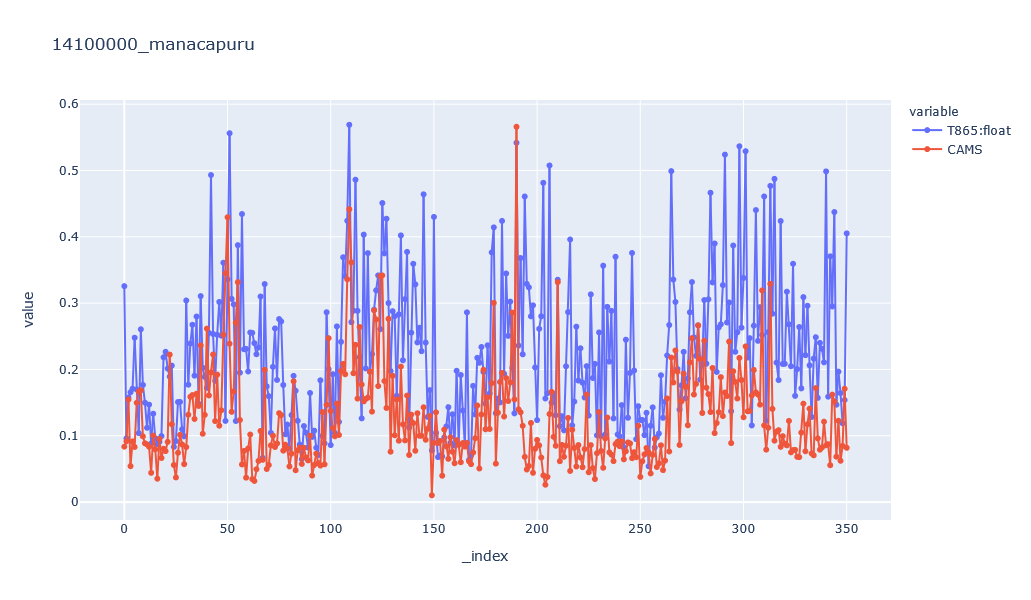

In [90]:
fig = px.line(dbs_manacapuru, y=['T865:float','CAMS'], height=600, title="14100000_manacapuru")
fig.update_traces(mode="markers+lines", hovertemplate=None)
fig.update_layout(hovermode="x unified")
fig.show()

In [12]:
out_20161023 = open_radiometry(Path(r'D:\processing\linux\14100000_manacapuru_v15\S3A_OL_2_WFR____20161023T134933_20161023T135133_20171104T083102_0119_010_124______MR1_R_NT_002.csv'))

In [13]:
db_scan(out_20161023, ['B17-865', 'B21-1020'], eps=0.01)

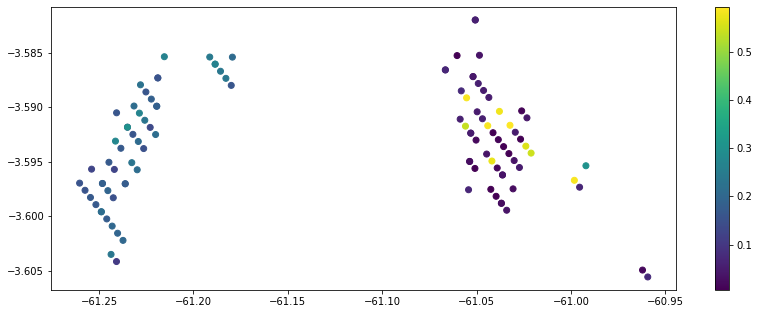

In [14]:
plt.rcParams['figure.figsize'] = [14, 5.2]
plt.scatter(out_20161023['longitude:double'],out_20161023['latitude:double'],c=out_20161023['T865:float'])
plt.colorbar()

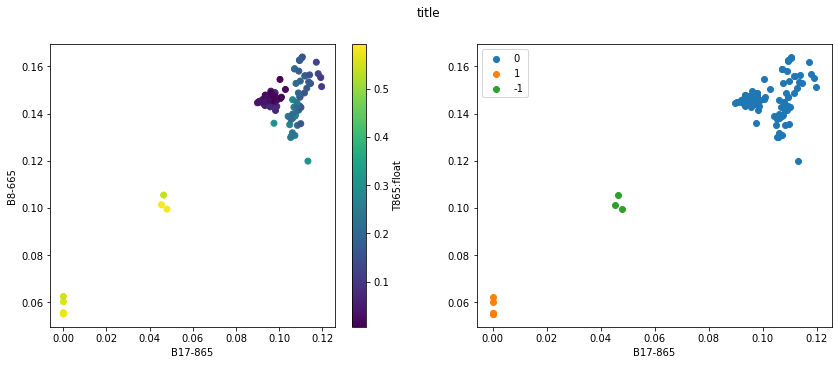

In [62]:
colors = {-1:'C0', 0:'C1', 1:'C2', 2:'C3', 3:'C4', 4:'C5', 5:'C6', 6:'C7', 7:'C8', 8:'C9'}

plt.rcParams['figure.figsize'] = [14, 5.2]
fig, (ax1, ax2) = plt.subplots(1, 2)

fig.suptitle('title')

skt1 = ax1.scatter(out_20161023['B17-865'], out_20161023['B8-665'], c=out_20161023['T865:float'], cmap='viridis')
cbar = fig.colorbar(skt1, ax=ax1)
cbar.set_label('T865:float')

# Get unique names of species
uniq = list(set(out_20161023['cluster']))

# Plot each species
for i in range(len(uniq)):
    indx = out_20161023['cluster'] == uniq[i]
    ax2.scatter(out_20161023['B17-865'][indx], out_20161023['B8-665'][indx], label=uniq[i])

# skt2 = ax2.scatter(out_20161023['B17-865'],out_20161023['B8-665'], s=3, c=out_20161023['cluster'].map(colors))
# cbar = fig.colorbar(skt2, ax=ax2)
# cbar.set_label('DBS:cluster')

ax1.set_xlabel('B17-865')  # RED: Oa08 (865nm)
ax1.set_ylabel('B8-665')  # NIR: Oa17 (665nm)
ax2.set_xlabel('B17-865')

#plt.savefig(savepathname, dpi=self.imgdpi, bbox_inches='tight')
#plt.close(fig)
plt.legend()
plt.show()

In [63]:
def plot_scattercluster(event_df, col_x='B17-865', col_y='B8-665', col_color='T865:float', cluster_col='cluster', mplcolormap='viridis', title=None, savepath=None, dpi=100):
    
    plt.rcParams['figure.figsize'] = [14, 5.2]
    fig, (ax1, ax2) = plt.subplots(1, 2)
    
    if title:
        fig.suptitle(title)

    skt1 = ax1.scatter(event_df[col_x], event_df[col_y], c=event_df[col_color], cmap=mplcolormap)
    cbar = fig.colorbar(skt1, ax=ax1)
    cbar.set_label(col_color)

    # Get unique names of clusters
    uniq = list(set(event_df[cluster_col]))

    # iterate to plot each cluster
    for i in range(len(uniq)):
        indx = event_df[cluster_col] == uniq[i]
        ax2.scatter(event_df[col_x][indx], event_df[col_y][indx], label=uniq[i])

    ax1.set_xlabel(col_x)
    ax1.set_ylabel(col_y)
    ax2.set_xlabel(col_x)
    
    plt.legend()
    
    if savepath:
        plt.savefig(savepath, dpi=dpi, bbox_inches='tight')
        plt.close(fig)
    else:
        plt.show()

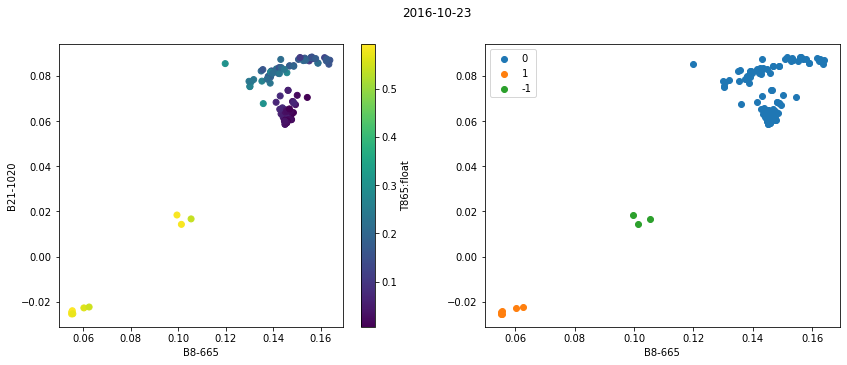

In [67]:
plot_scattercluster(out_20161023,col_x='B8-665', col_y='B21-1020',title='2016-10-23')

In [68]:
dbs_manacapuru

index  A865:float  ABSVLDPX    B1-400  B10-681.25  B11-708.75  \
0    20160502    0.361417     121.0  0.009124    0.055231    0.049974   
1    20160506    1.414920    2138.0  0.038581    0.099125    0.090490   
2    20160510    1.379418    1804.0  0.038186    0.098208    0.089976   
3    20160514    1.015384    3173.0  0.013317    0.091796    0.083611   
4    20160518    1.097721    2737.0  0.009355    0.091160    0.083228   
..        ...         ...       ...       ...         ...         ...   
346  20200322    1.484181    2219.0 -0.000342    0.138829    0.137225   
347  20200324    1.327190    3170.0 -0.002117    0.124244    0.121568   
348  20200325    1.535273    3374.0 -0.023360    0.128145    0.130936   
349  20200326    1.583813    3301.0 -0.015884    0.131645    0.129853   
350  20200328    0.945069    1490.0 -0.011678    0.125500    0.121610   

     B12-753.75  B16-778.75   B17-865   B18-885  ...   Unnamed: 0  \
0      0.027054    0.029158  0.016413  0.013544  ...     6.400000   
1      0.045708    0.048633  0.029324  0.025374  ...   484.945556   
2      0.047014    0.049487  0.030050  0.026079  ...   512.734916   
3      0.041500    0.044299  0.026440  0.022731  ...   752.800000   
4      0.043866    0.046003  0.027505  0.023641  ...   674.094686   
..          ...         ...       ...       ...  ...          ...   
346    0.084361    0.082697  0.055589  0.048998  ...   368.485612   
347    0.077202    0.080657  0.055388  0.049376  ...  1045.099676   
348    0.084279    0.082804  0.056044  0.049205  ...  1533.412009   
349    0.083601    0.083191  0.056393  0.049475  ...  1252.266275   
350    0.080919    0.081872  0.055827  0.049258  ...    92.972789   

     WQSF_lsb:double  latitude:double  longitude:double     mndwi      ndwi  \
0       3.164128e+11        -3.598079        -61.265197  0.745186  0.418096   
1       3.819247e+11        -3.423791        -60.789509  0.769922  0.430605   
2       3.669424e+11        -3.588761        -61.056066  0.716444  0.417685   
3       7.163950e+11        -3.464980        -60.779576  0.728572  0.420529   
4       8.540179e+11        -3.450933        -60.762388  0.673395  0.402426   
..               ...              ...               ...       ...       ...   
346     1.756111e+12        -3.469991        -60.789541  0.640349  0.265180   
347     1.799038e+12        -3.493859        -60.858498  0.657654  0.232636   
348     3.954293e+12        -3.499846        -60.900012  0.629148  0.203721   
349     3.084852e+12        -3.484235        -60.835041  0.649487  0.222917   
350     2.459246e+12        -3.578026        -61.113753  0.560838  0.198431   

               x            y     Datestr       Date  
0     740.300000  3484.100000  2016-05-02 2016-05-02  
1     653.537778  3283.371111  2016-05-06 2016-05-06  
2     741.369931  2815.713155  2016-05-10 2016-05-10  
3     679.683077  2539.957949  2016-05-14 2016-05-14  
4     673.002899  2169.839614  2016-05-18 2016-05-18  
..           ...          ...         ...        ...  
346   839.329137  2160.697842  2020-03-22 2020-03-22  
347   661.384117  3074.483793  2020-03-24 2020-03-24  
348  1222.158891   435.153349  2020-03-25 2020-03-25  
349   927.013110  1768.606239  2020-03-26 2020-03-26  
350   790.639456  2604.653061  2020-03-28 2020-03-28  

[351 rows x 36 columns]

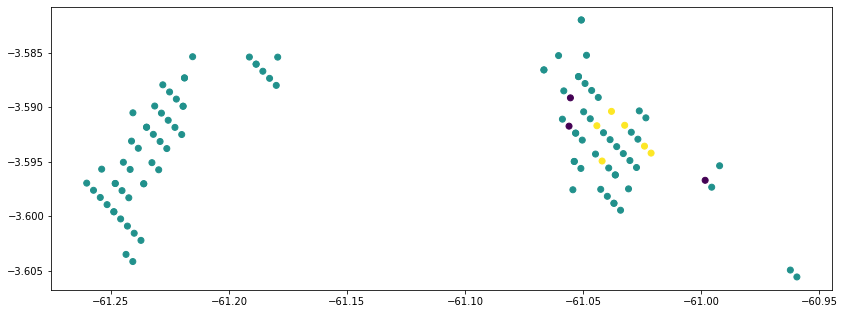

In [74]:
plt.scatter(out_20161023['longitude:double'], out_20161023['latitude:double'], c=out_20161023['cluster'])

In [2]:
import sys
sys.path.append('../../')
from nc_explorer import NcExplorer
import utils as s3u

sen3r-NcExplorer: from mpl_toolkits.basemap import Basemap FAILED!
You can still proceed without plotting any maps.



In [3]:
vertx = s3u.geojson_to_polygon('/d_drive_data/A1_JM/artigo_SEN3R/2_mat_met/study_area/geojson/15860000_borba_madeira.geojson')

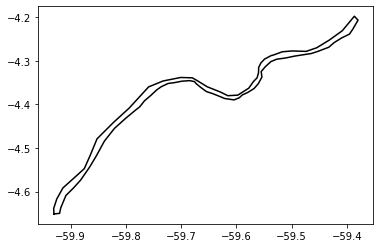

In [7]:
for vert in vertx:
    plt.plot(vert[:,0],vert[:,1],c='k')

In [8]:
path = Path('D:/S3/L2_WFR/S3A_OL_2_WFR____20191104T135002_20191104T135302_20191124T134508_0179_051_124_3060_MAR_O_NT_002.SEN3')
# path = Path('/d_drive_data/S3/L2_WFR/S3A_OL_2_WFR____20191104T135002_20191104T135302_20191124T134508_0179_051_124_3060_MAR_O_NT_002.SEN3')
ncxp = NcExplorer(input_nc_folder=path, product='wfr')

Declaring class instance from: SEN3R:nc_explorer
Reading valid NetCDF files inside image folder...
Product set to WFR.
Loading image bands into memory, this may take a while...


In [10]:
%time xy_vertices, ll_vertices = ncxp.get_xy_polygon_from_json(poly_path='D:\\A1_JM\\areas\\paper_areas\\14100000_manacapuru.geojson', parallel=False)

Wall time: 13.2 s


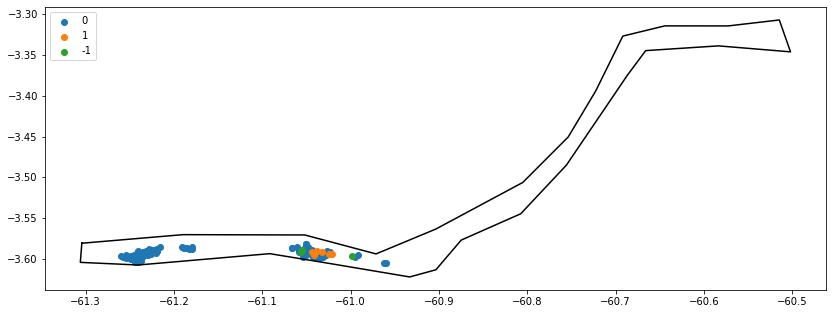

In [15]:
colors = {-1:'C0', 0:'C1', 1:'C2', 2:'C3', 3:'C4', 4:'C5', 5:'C6', 6:'C7', 7:'C8', 8:'C9'}

for vert in ll_vertices:
    plt.plot(vert[:,0],vert[:,1],c='k')

    # Get unique names of clusters
    uniq = list(set(out_20161023['cluster']))

    # iterate to plot each cluster
    for i in range(len(uniq)):
        indx = out_20161023['cluster'] == uniq[i]
        plt.scatter(out_20161023['longitude:double'][indx], out_20161023['latitude:double'][indx], label=uniq[i])

plt.legend()
plt.show()

In [91]:
out_20161023['cluster'].unique()

array([ 0, -1,  1], dtype=int64)